In [103]:
# THIS CELL NEEDS TO BE RUN EVERY TIME
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

# from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import textwrap

from google.colab import drive
drive.mount('/content/drive')

fastica = loadmat("drive/MyDrive/comp_neuro/ecog_data/icasig.mat")['icasig'] # sampled at 250Hz
mtx = loadmat("drive/MyDrive/comp_neuro/ecog_data/mtx.mat")['mtx'] # sampled at 250Hz
eyetrack = loadmat("drive/MyDrive/comp_neuro/ecog_data/EyeTrack.mat") # sampled at 120Hz
event = loadmat("drive/MyDrive/comp_neuro/ecog_data/Event.mat")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [104]:
# 59 components for 90% of variance, according to PCA (see matlab code)
# fastica = np.delete(fastica_orig[:59], [0, 1, 2, 3, 4, 10, 43, 45, 46], axis=0)
# fastica=fastica_orig[:59]

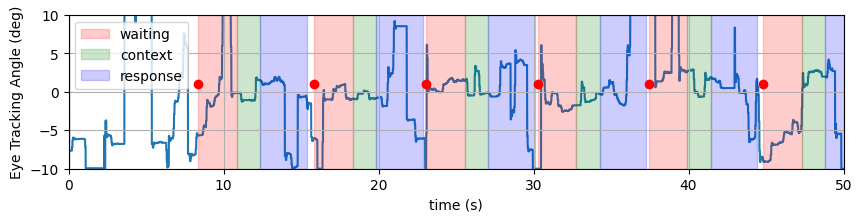

In [105]:
look_angle = eyetrack['EyeTrackData'].T[2, :]

fig, ax = plt.subplots(figsize=(10, 2))
ax.plot(np.linspace(0, look_angle.shape[0] / 120, look_angle.shape[0]), look_angle, zorder=1)
ax.scatter(event['EventTime'], np.linspace(1, 1, event['EventTime'].shape[1]), c='red', zorder=3)
ax.set(xlabel='time (s)', ylabel='Eye Tracking Angle (deg)')
ax.grid()


for t in event['EventTime'][0]:
  ax.axvspan(t, t + 2.5, alpha=0.2, color='red')
  ax.axvspan(t + 2.5, t + 4, alpha=0.2, color='green')
  ax.axvspan(t + 4, t + 7, alpha=0.2, color='blue')

# labels for legend
ax.axvspan(0, 0, alpha=0.2, color='red', label='waiting')
ax.axvspan(0, 0, alpha=0.2, color='green', label='context')
ax.axvspan(0, 0, alpha=0.2, color='blue', label='response')
plt.legend()

plt.xlim(0, 50)
plt.ylim(-10, 10)
plt.show()

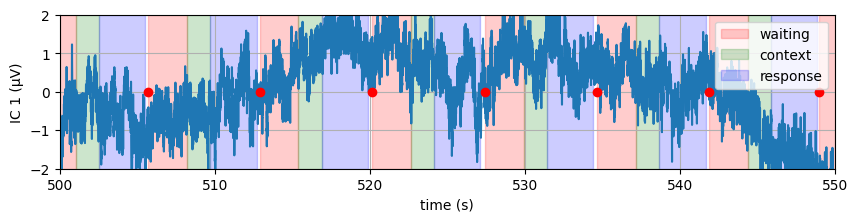

In [106]:
look_angle = eyetrack['EyeTrackData'].T[2, :]

fig, ax = plt.subplots(figsize=(10, 2))
ax.plot(np.linspace(0, fastica.shape[1] / 250, fastica.shape[1]), fastica[4], zorder=2)
ax.scatter(event['EventTime'], np.linspace(0, 0, event['EventTime'].shape[1]), c='red', zorder=3)
ax.set(xlabel='time (s)', ylabel='IC 1 (μV)')
ax.grid()


for t in event['EventTime'][0]:
  ax.axvspan(t, t + 2.5, alpha=0.2, color='red')
  ax.axvspan(t + 2.5, t + 4, alpha=0.2, color='green')
  ax.axvspan(t + 4, t + 7, alpha=0.2, color='blue')

# labels for legend
ax.axvspan(0, 0, alpha=0.2, color='red', label='waiting')
ax.axvspan(0, 0, alpha=0.2, color='green', label='context')
ax.axvspan(0, 0, alpha=0.2, color='blue', label='response')
plt.legend(loc='upper right')

plt.xlim(500, 550)
plt.ylim(-2, 2)
plt.show()

In [107]:
# THIS CELL NEEDS TO BE RUN EVERY TIME

binsize = 250 # 1second * 250Hz
n = len(event['EventData'][0])

X = np.zeros((n * 3, 128 * binsize))
y = np.zeros((n * 3,))

pruned = fastica.copy()
for i in range(n):
  # context
  # begin = int(event['EventTime'][0][i] + 4 * 250)
  waiting = int(event['EventTime'][0][i] + 0 * 250)
  context = int(event['EventTime'][0][i] + 2.5 * 250)
  response = int(event['EventTime'][0][i] + 4 * 250)

  X[i*3] = np.hstack(pruned[:,waiting:waiting+binsize])
  X[i*3+1] = np.hstack(pruned[:,context:context+binsize])
  X[i*3+2] = np.hstack(pruned[:,response:response+binsize])
  y[i*3] = 0
  y[i*3+1] = 1
  y[i*3+2] = 2


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [108]:
# THIS CELL NEEDS TO BE RUN EVERY TIME

binsize = 250 # 1second * 250Hz
n = len(event['EventData'][0])

X = np.zeros((n * 3, 128 * binsize))
y = np.zeros((n * 3,))

pruned = mtx.copy()
for i in range(n):
  # context
  # begin = int(event['EventTime'][0][i] + 4 * 250)
  waiting = int(event['EventTime'][0][i] + 0 * 250)
  context = int(event['EventTime'][0][i] + 2.5 * 250)
  response = int(event['EventTime'][0][i] + 4 * 250)

  X[i*3] = np.hstack(pruned[:,waiting:waiting+binsize])
  X[i*3+1] = np.hstack(pruned[:,context:context+binsize])
  X[i*3+2] = np.hstack(pruned[:,response:response+binsize])
  y[i*3] = 0
  y[i*3+1] = 1
  y[i*3+2] = 2


X_train_noica, X_test_noica, y_train_noica, y_test_noica = train_test_split(X, y, test_size=0.25)

# Random Forest

Train reg score: 0.8844444444444445


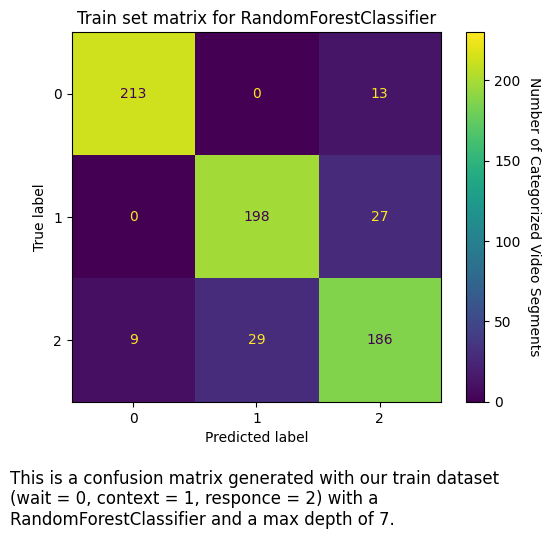

Test reg score: 0.24


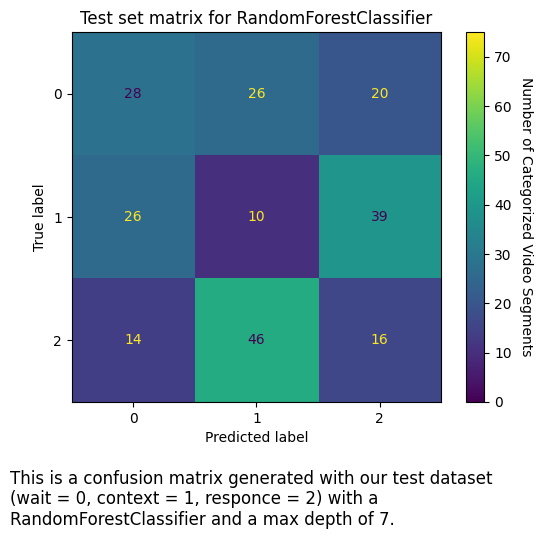

In [109]:


reg = RandomForestClassifier(max_depth=7)
# copy everything after this comment for reproducability with desired model
model_name = reg.__class__.__name__


reg.fit(X_train, y_train)

y_pred = reg.predict(X_train)
print("Train reg score: " + str(reg.score(X_train, y_train)))

cm = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(colorbar=False)

disp.im_.set_clim(0, 230)

plt.title("Train set matrix for " + str(model_name))
train_caption = "This is a confusion matrix generated with our train dataset (wait = 0, context = 1, responce = 2) with a " + str(model_name) + " and a max depth of 7."
train_wrapped_text = textwrap.fill(train_caption, width=60)
plt.text(-1,3.5, train_wrapped_text, fontsize=12)


cbar = plt.colorbar(disp.im_, ax=disp.ax_)
cbar.set_label('Number of Categorized Video Segments', rotation=270, labelpad=15)
plt.show()



test_y_pred = reg.predict(X_test)
print("Test reg score: " + str(reg.score(X_test, y_test)))

cm_test = confusion_matrix(y_test, test_y_pred)
test_disp = ConfusionMatrixDisplay(confusion_matrix=cm_test)
test_disp.plot(colorbar=False)

test_disp.im_.set_clim(0, 75)

plt.title("Test set matrix for " + str(model_name))
test_caption = "This is a confusion matrix generated with our test dataset (wait = 0, context = 1, responce = 2) with a " + str(model_name) + " and a max depth of 7."
test_wrapped_text = textwrap.fill(test_caption, width=60)
plt.text(-1,3.5, test_wrapped_text, fontsize=12)

test_cbar = plt.colorbar(test_disp.im_, ax=test_disp.ax_)
test_cbar.set_label('Number of Categorized Video Segments', rotation=270, labelpad=15)
plt.show()


# Ada Boost

Train reg score: 0.45481481481481484


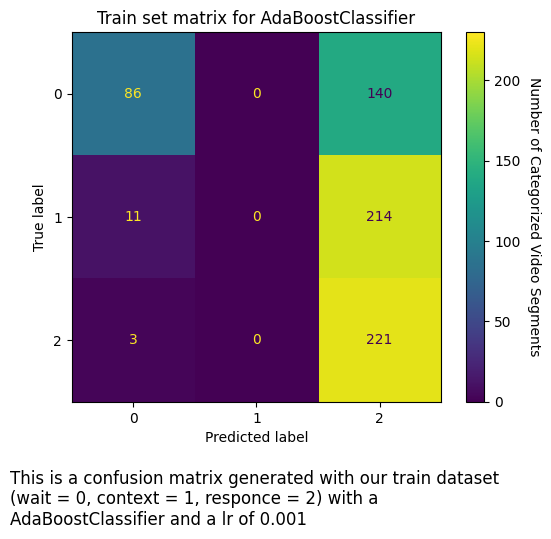

Test reg score: 0.38222222222222224


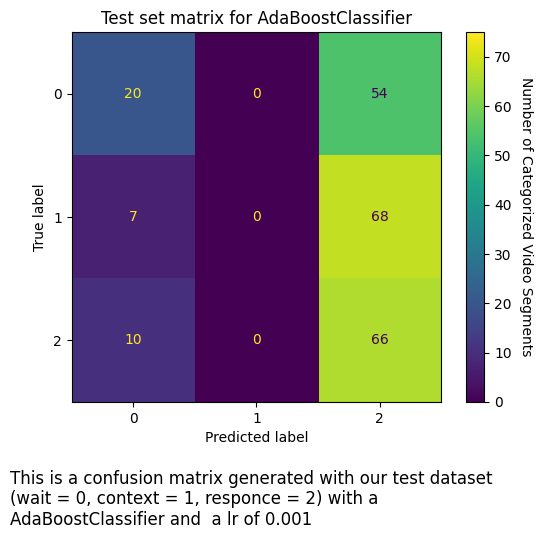

In [110]:
# reg = AdaBoostClassifier()
lr = .001
reg = AdaBoostClassifier(learning_rate = lr)

# copy everything after this comment for reproducability with desired model
model_name = reg.__class__.__name__


reg.fit(X_train, y_train)

y_pred = reg.predict(X_train)
print("Train reg score: " + str(reg.score(X_train, y_train)))

cm = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(colorbar=False)

disp.im_.set_clim(0, 230)

plt.title("Train set matrix for " + str(model_name))
train_caption = "This is a confusion matrix generated with our train dataset (wait = 0, context = 1, responce = 2) with a " + str(model_name) + " and a lr of " + str(lr)
train_wrapped_text = textwrap.fill(train_caption, width=60)
plt.text(-1,3.5, train_wrapped_text, fontsize=12)

cbar = plt.colorbar(disp.im_, ax=disp.ax_)
cbar.set_label('Number of Categorized Video Segments', rotation=270, labelpad=15)
plt.show()



test_y_pred = reg.predict(X_test)
print("Test reg score: " + str(reg.score(X_test, y_test)))

cm_test = confusion_matrix(y_test, test_y_pred)
test_disp = ConfusionMatrixDisplay(confusion_matrix=cm_test)
test_disp.plot(colorbar=False)

test_disp.im_.set_clim(0, 75)

plt.title("Test set matrix for " + str(model_name))
test_caption = "This is a confusion matrix generated with our test dataset (wait = 0, context = 1, responce = 2) with a " + str(model_name) + " and  a lr of " + str(lr)
test_wrapped_text = textwrap.fill(test_caption, width=60)
plt.text(-1,3.5, test_wrapped_text, fontsize=12)

test_cbar = plt.colorbar(test_disp.im_, ax=test_disp.ax_)
test_cbar.set_label('Number of Categorized Video Segments', rotation=270, labelpad=15)
plt.show()


# XGBoost (sklearn)

Train reg score: 0.5392592592592592


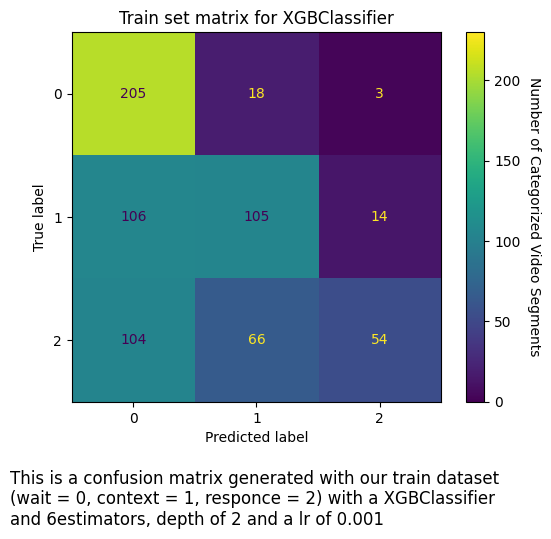

Test reg score: 0.4311111111111111


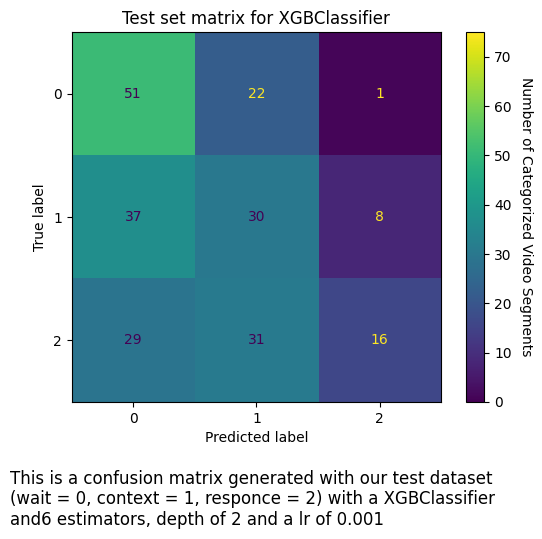

In [111]:

# create model instance

est = 6
depth = 2
lr = .001

reg = XGBClassifier(n_estimators=est, max_depth=depth, learning_rate=lr, objective='multi:softmax')
# copy everything after this comment for reproducability with desired model
model_name = reg.__class__.__name__


reg.fit(X_train, y_train)

y_pred = reg.predict(X_train)
print("Train reg score: " + str(reg.score(X_train, y_train)))

cm = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(colorbar=False)

disp.im_.set_clim(0, 230)

plt.title("Train set matrix for " + str(model_name))
train_caption = "This is a confusion matrix generated with our train dataset (wait = 0, context = 1, responce = 2) with a " + str(model_name) + " and " + str(est) + "estimators, depth of "  + str(depth) + " and a lr of " + str(lr)
train_wrapped_text = textwrap.fill(train_caption, width=60)
plt.text(-1,3.5, train_wrapped_text, fontsize=12)


cbar = plt.colorbar(disp.im_, ax=disp.ax_)
cbar.set_label('Number of Categorized Video Segments', rotation=270, labelpad=15)
plt.show()



test_y_pred = reg.predict(X_test)
print("Test reg score: " + str(reg.score(X_test, y_test)))

cm_test = confusion_matrix(y_test, test_y_pred)
test_disp = ConfusionMatrixDisplay(confusion_matrix=cm_test)
test_disp.plot(colorbar=False)

test_disp.im_.set_clim(0, 75)

plt.title("Test set matrix for " + str(model_name))
test_caption = "This is a confusion matrix generated with our test dataset (wait = 0, context = 1, responce = 2) with a " + str(model_name) + " and" + str(est) + " estimators, depth of "  + str(depth) + " and a lr of " + str(lr)
test_wrapped_text = textwrap.fill(test_caption, width=60)
plt.text(-1,3.5, test_wrapped_text, fontsize=12)

test_cbar = plt.colorbar(test_disp.im_, ax=test_disp.ax_)
test_cbar.set_label('Number of Categorized Video Segments', rotation=270, labelpad=15)
plt.show()

# XGBoost (xgboost)

In [127]:
from xgboost import XGBClassifier

def runxgb(est, depth, lr, use_ica):
  reg = XGBClassifier(n_estimators=est, max_depth=depth, learning_rate=lr, objective='multi:softmax')

  if use_ica:
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_train)
    test_y_pred = reg.predict(X_test)

    cm = confusion_matrix(y_train, y_pred)
    cm_test = confusion_matrix(y_test, test_y_pred)

    print("Test reg score (ICA): " + str(reg.score(X_test, y_test)))
    print("Train reg score (ICA): " + str(reg.score(X_train, y_train)))
  else:
    reg.fit(X_train_noica, y_train_noica)
    y_pred = reg.predict(X_train_noica)
    test_y_pred = reg.predict(X_test_noica)

    cm = confusion_matrix(y_train_noica, y_pred)
    cm_test = confusion_matrix(y_test_noica, test_y_pred)

    print("Test reg score (No ICA): " + str(reg.score(X_test_noica, y_test_noica)))
    print("Train reg score (No ICA): " + str(reg.score(X_train_noica, y_train_noica)))

  # train confusion matrix
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['wait', 'context', 'response'])
  disp.plot(colorbar=False)
  # disp.im_.set_clim(0, 230)
  plt.title(f"XGBoost On Train (ICA = {use_ica})")
  cbar = plt.colorbar(disp.im_, ax=disp.ax_)
  cbar.set_label('# Sampled Video Segments', rotation=270, labelpad=15)
  plt.show()

  # test confusion matrix
  test_disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['wait', 'context', 'response'])
  test_disp.plot(colorbar=False)
  # test_disp.im_.set_clim(0, 75)
  plt.title(f"XGBoost On Test (ICA = {use_ica})")
  test_cbar = plt.colorbar(test_disp.im_, ax=test_disp.ax_)
  test_cbar.set_label('# Sampled Video Segments', rotation=270, labelpad=15)
  plt.show()

Test reg score (ICA): 0.4311111111111111
Train reg score (ICA): 0.5392592592592592


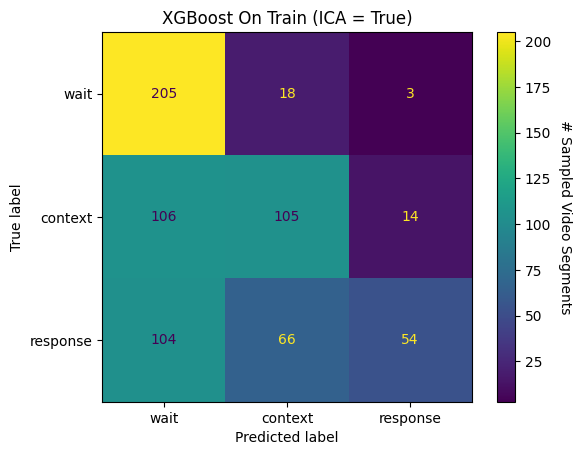

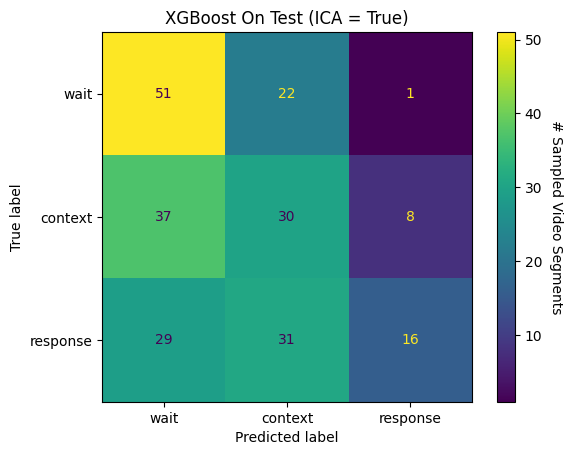

In [128]:
runxgb(4, 2, 0.001, True)

Test reg score (No ICA): 0.39111111111111113
Train reg score (No ICA): 0.56


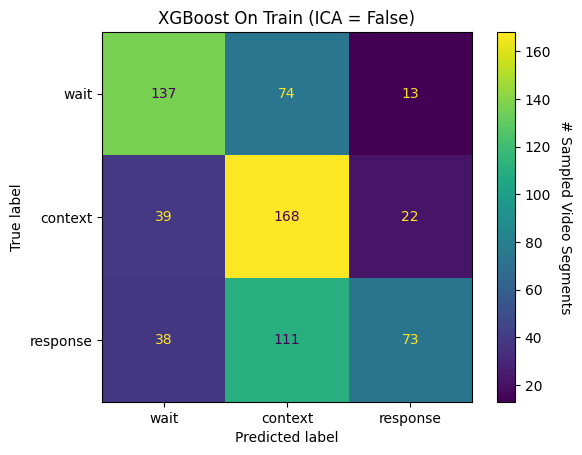

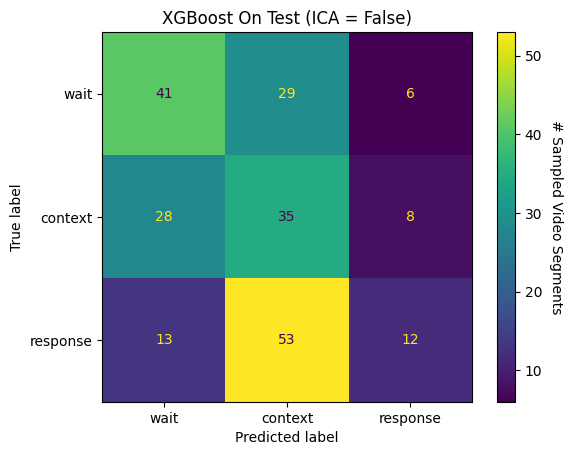

In [114]:
runxgb(4, 2, 0.001, False)

Test reg score (ICA): 0.3333333333333333
Train reg score (ICA): 0.6888888888888889


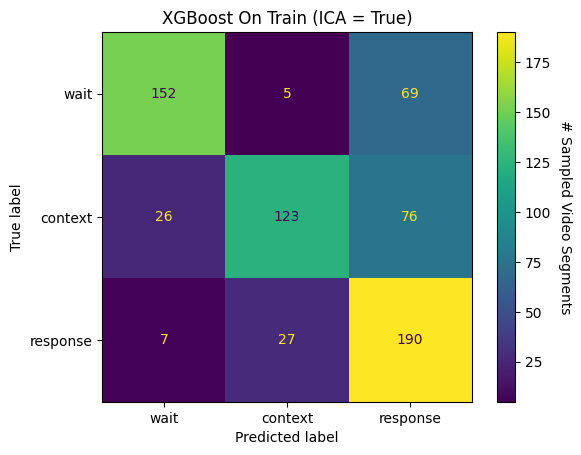

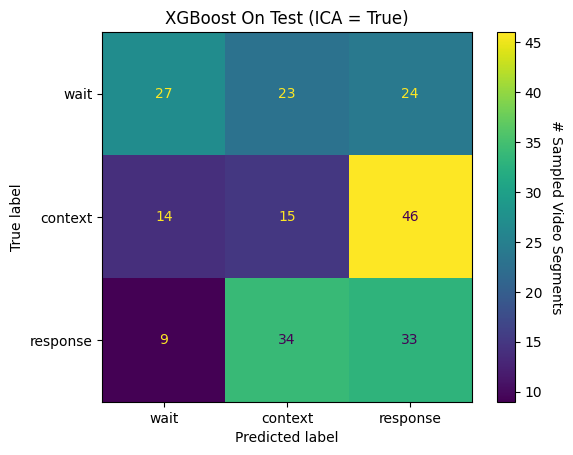

In [115]:
runxgb(6, 4, 0.001, True)

Test reg score (No ICA): 0.3244444444444444
Train reg score (No ICA): 0.7185185185185186


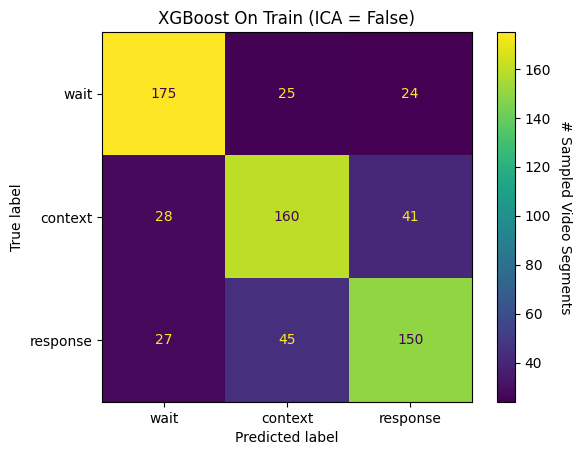

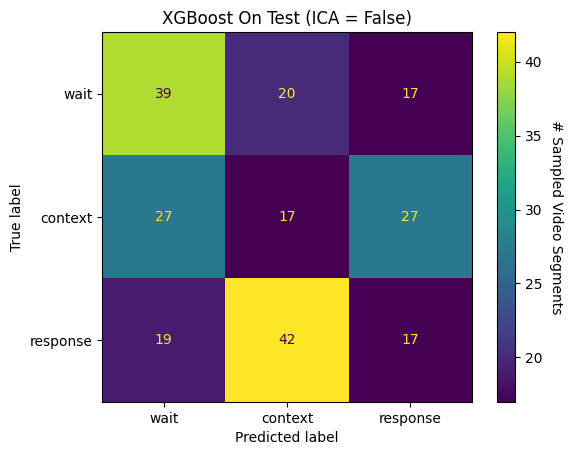

In [116]:
runxgb(6, 4, 0.001, False)

Test reg score (ICA): 0.4311111111111111
Train reg score (ICA): 0.5392592592592592


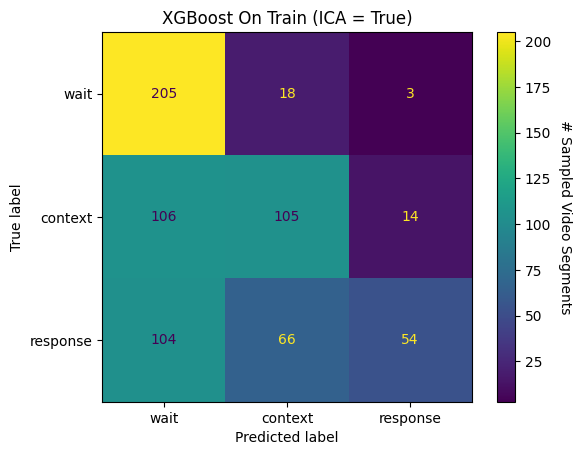

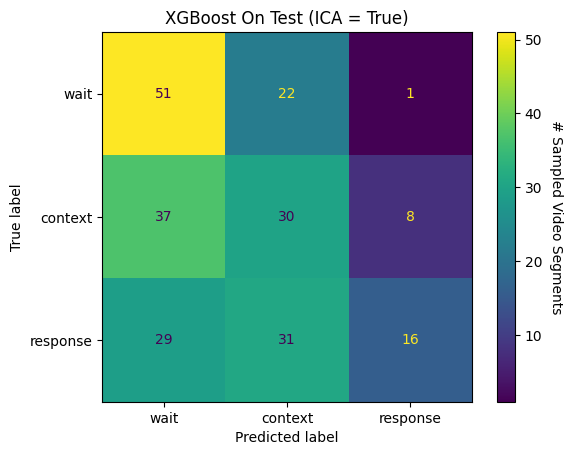

In [129]:
runxgb(6, 2, 0.001, True)

Test reg score (No ICA): 0.39111111111111113
Train reg score (No ICA): 0.56


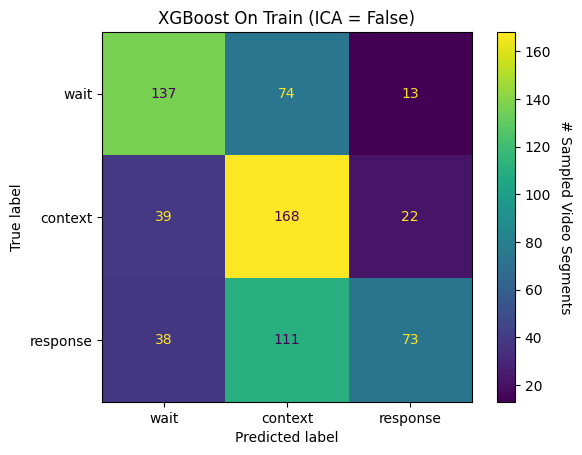

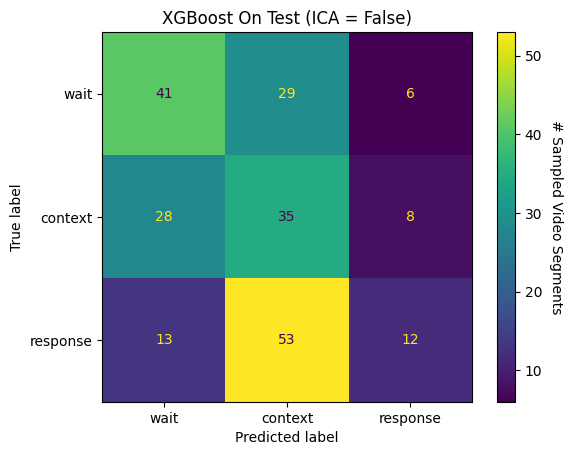

In [130]:
runxgb(6, 2, 0.001, False)